<h2>Motorcycles EDA</h2>

<strong style='color:orange ; background-color:black;'> Quick NOTE:
This notebook was designed for DARK MODE.</strong> The notebook is still perfectly functional in light-mode, but if you'd like the best experience, I recommend changing it! 

Furthermore, the tables markdown function is not yet functional in github.com. Therefore, I recommend using an IDE like Visual Studio or PyCharm.

<h4><b>Dataset name / short description:</b></h4>

Motorcycle Sales Data

<h4><b>Data source (url):</b></h4>

<strong style='color:red'>[REDACTED]</color>

<h4><b>Data format:</b></h4>

.CSV format, comma delimited

<h4><b>Data description, features and limitations:</b></h4>

|Features|
|---|
|Columns: name, selling_price, year, seller_type, owner, km_driven, ex_showroom_price|
| The name includes the make and model of the bike|
| Total 1061 rows of data| 

Let's go over the limitations:

|Limitations|
|---|
|There are no column descriptions provided. For example, the Year column could be the year sold, or the age of the bike.|
|There is no 'features' column, which would be useful to see if certain extras on the bike will make the value go up a lot. (extra bells and whistles) | 
|The selling price doesn't mention the currency type|
| One column has an abundant amount of missing values (ex_showroom_price)|
| Because there are only a few 'dealership' rows in this dataset, this data is effectively <strong style='color:orange ; background-color:black;'>only INDIVIDUAL SALES data. </strong> |

<h3><b>Code: importing modules, custom functions and loading the data</b></h3>

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("motorcycle_sales.csv")
df

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN
...,...,...,...,...,...,...,...
1056,Activa 3g,17000,2010,Individual,1st owner,500000,52000.0
1057,Honda CB twister,16000,2012,Individual,1st owner,33000,51000.0
1058,Bajaj Discover 125,15000,2013,Individual,2nd owner,35000,57000.0
1059,Honda CB Shine,12000,2009,Individual,1st owner,53000,58000.0


---

<h1><b>Code: Data clean-up procedure</b></h1>

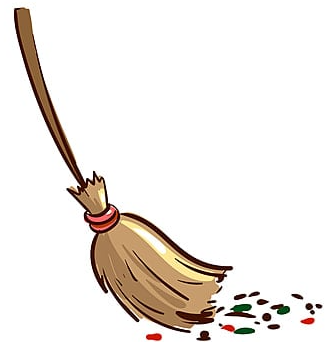


|Procedures done|
|---|
|Changing data types|
|Dropping the ex_showroom_price, due to abundant missing values (50% approx)|
|Dropping the seller column (due to distribution problems)|
|Converting categorical to nominal columns|
|Creating a separate correlation dataframe, which uses |
|Creating and applying a function to convert the owner column to a nominal column. |
|Made two functions that divided the model and the make (ROUGHLY, enough to do analytics)|
|Removing outliers by selling price|


In [161]:
# That's quite a few null values, let's drop the column.
df.isna().sum()

# The amount of approximate values missing is about 50% let's drop this column.


name                   0
selling_price          0
year                   0
seller_type            0
owner                  0
km_driven              0
ex_showroom_price    435
dtype: int64

In [162]:
# Dropping the column.
df = df.drop('ex_showroom_price', axis=1)


In [163]:
# Let's replace this with numbers, it's more useful that way (for correlations and such)
df['owner'].value_counts()

# We fill the mapper with all the values we're going to translate
category_mapper = {'1st owner':1,
                   '2nd owner':1,
                   '3rd owner':2,
                   '4th owner':3
}

# And we apply the mapper.
df['owner'] = df['owner'].map(category_mapper)

In [164]:
# Next up, we'll make a custom function that divides the model and make
# This is a bit of a rough solution, but the main idea is to get insights anyways.


def make_divider(row):
    row = row.split(" ")
    row = row[0]
    return row

# And we'll apply the function.
df['make'] = df['name'].apply(make_divider)

In [165]:
# This custom function will roughly get the make of the motorcycle
def model_parser(row):
    row = row.split(" ")
    row.pop(0)
    row = " ".join(row)
    return row

# And we'll apply the function.
df['model'] = df['name'].apply(model_parser)

In [166]:
# Let's find out what the distribution looks like!

# There are a couple selling prices that are skewing the data, making the pairplot a bit difficult to see.
# We'll remove those outliers.
df = df[df['selling_price'] < 200000]

# sns.displot(df, x='selling_price')

In [167]:
# There's some huge outliers here as well. Let's get rid of those too.
df = df[df['km_driven'] < 180000]

# sns.displot(df, x='km_driven')


### Separate Dataframe for correlations -- Turns seller type and 

In [ ]:
# Since there are only a few ownership categories, we should use OneHotEncoder on that (so we can try to use that to turn the categories
# nominal variables to see if it will help us in the correlation matrix.)

# Let's also save this dataset separately in case we would like the categorical variable (for example, plots)

df1 = df

from sklearn.preprocessing import OneHotEncoder
variables = ['seller_type']

encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
one_hot_encoded = encoder.fit_transform(df1[variables]).astype(int)
df1 = pd.concat([df1, one_hot_encoded], axis=1).drop(columns=variables)

### Filtered dataframe for 8 most popular makes

In [169]:
# Let's make a groupby series that counts all of the instances by make.
popular_makes = df.groupby(['make']).count()

# Let's filter out the name, because the rest isn't that important.
popular_makes = popular_makes['name']

# Now we sort out to see which ones are the most popular
popular_makes = popular_makes.sort_values(ascending=False)

# And we filter out the 8 most popular makes. The point of this is to not have too many categories, otherwise
# it will be too hard to see implots and scatters. READABILITY, CLARITY is key!
# Remember to reset the index (since right now, it's in a groupby series, NOT a pandas DF)
popular_makes = popular_makes.head(8).reset_index()
popular_makes = popular_makes['make']

# Finally, we filter out the column so that it only takes the popular makes using isin() function.
popular_makes = df[df['make'].isin(popular_makes)].reset_index()

### Owner Columns Distribution Problems Fix

In [170]:
# Here we can see that there is an ABSOLUTELY MASSIVE distribution skew here. I suspected as much. It doesn't make sense that 
# dealers make less money, they need it to sustain the business.
df['owner'].value_counts()

owner
1    1021
2      11
3       1
Name: count, dtype: int64

In [171]:
# More issues. The distribution for dealers is so small that it renders the column virtually unsusable. 
# Now it's just noise that affects the data. Let's filter it out.  It's now a dataset for just INDIVIDUAL motorcycle sales.
df['seller_type'].value_counts()

seller_type
Individual    1027
Dealer           6
Name: count, dtype: int64

In [172]:
# Let's filter out the 'Dealership' values.
df = df[df['seller_type'] == "Individual"]

# And since it is sort of redundant, let's also get rid of the column. This is NOW a dataset about Individual motorcycle sales data.
df = df.drop('seller_type', axis=1)

---

# Data Analytics


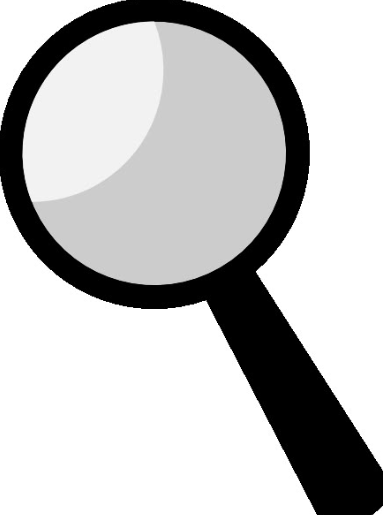

# Pairplots

Use separate markdown cells if you wish to emphasize an important point or additional information for the reader (see vehicle example)

## Motorcycle Makes Pairplot

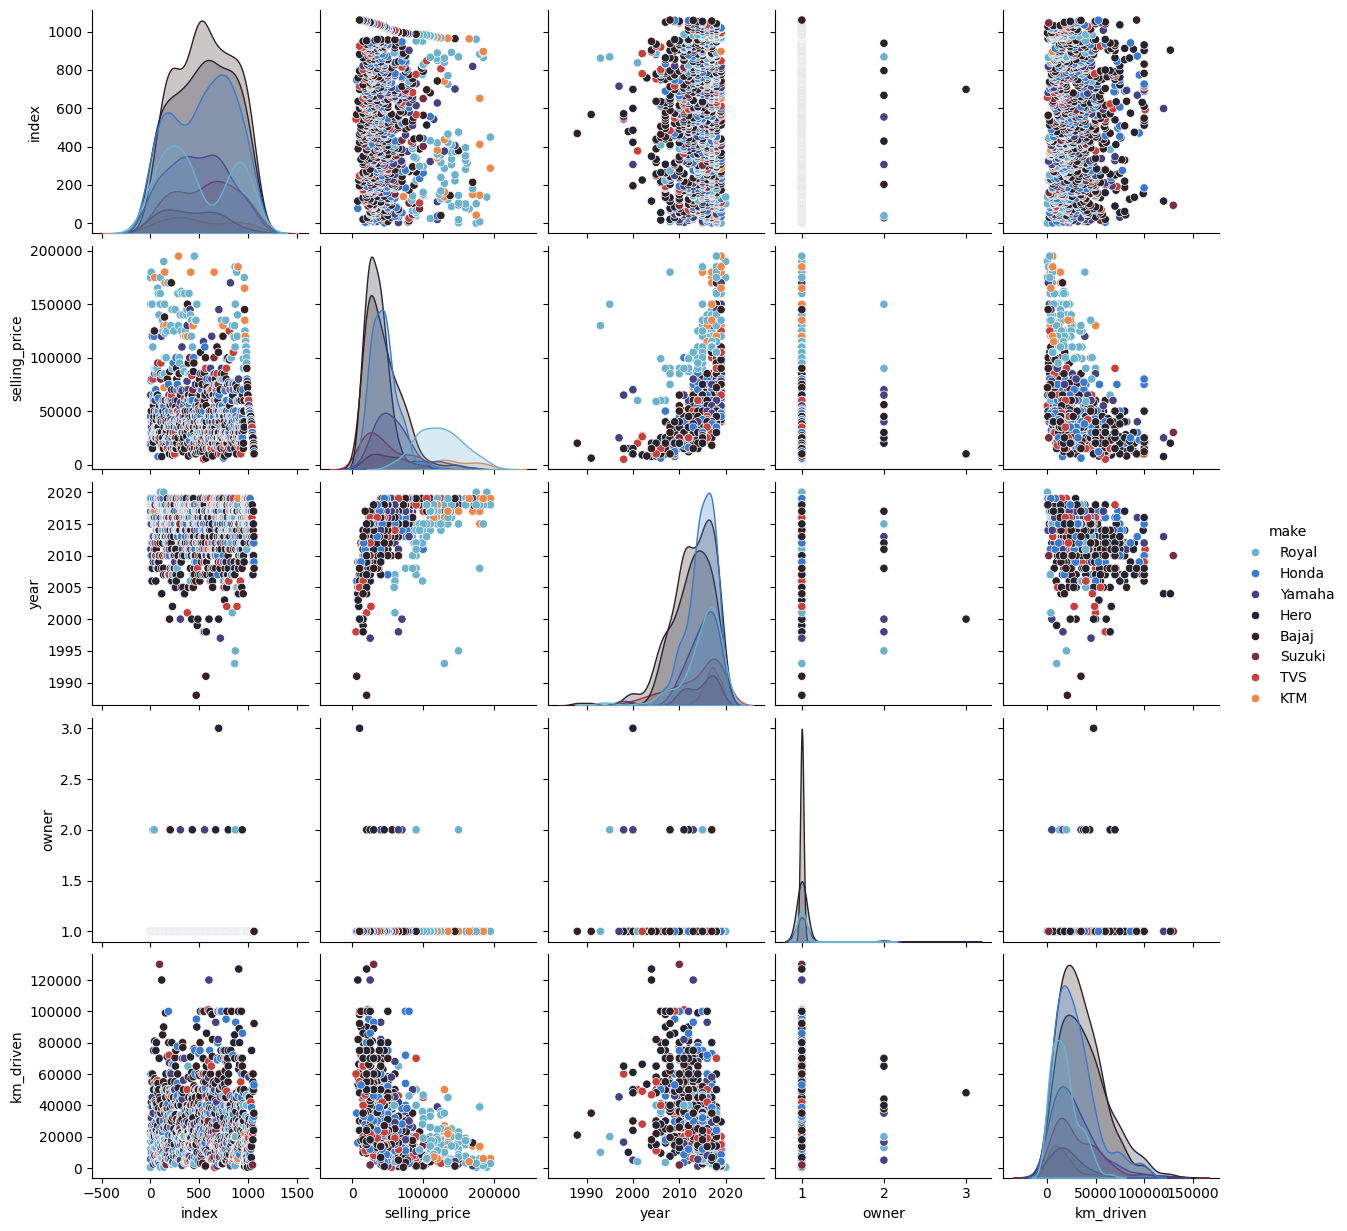

In [173]:
sns.pairplot(popular_makes, hue="make", palette='icefire')

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Pairplot Observations</h3>

When looking at the pairplot, we see a clear cluster for the Royal motorcycles make. <strong style='color:orange ; background-color:black;'> KTM and Royal motorcycles are more expensive than the traditional popular makes. </strong>

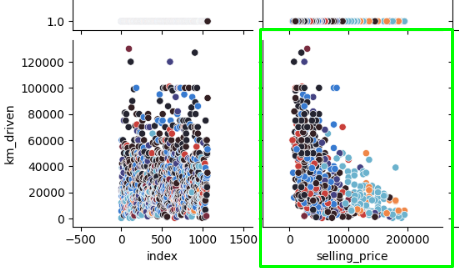

Yet, the distribution suggests <strong style='color:orange; background-color:black;'>Royal Motorcycles are only being sold at low odometer readings. </strong> This might be an indicator that Royal is a novelty/luxury brand. 

It also may be that these people might not drive these types of motorcycles very much. It's difficult to say what is causing this without more information.

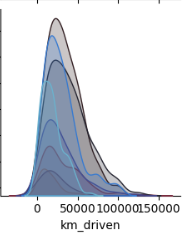

</div>

## Kilometers driven Pairplot

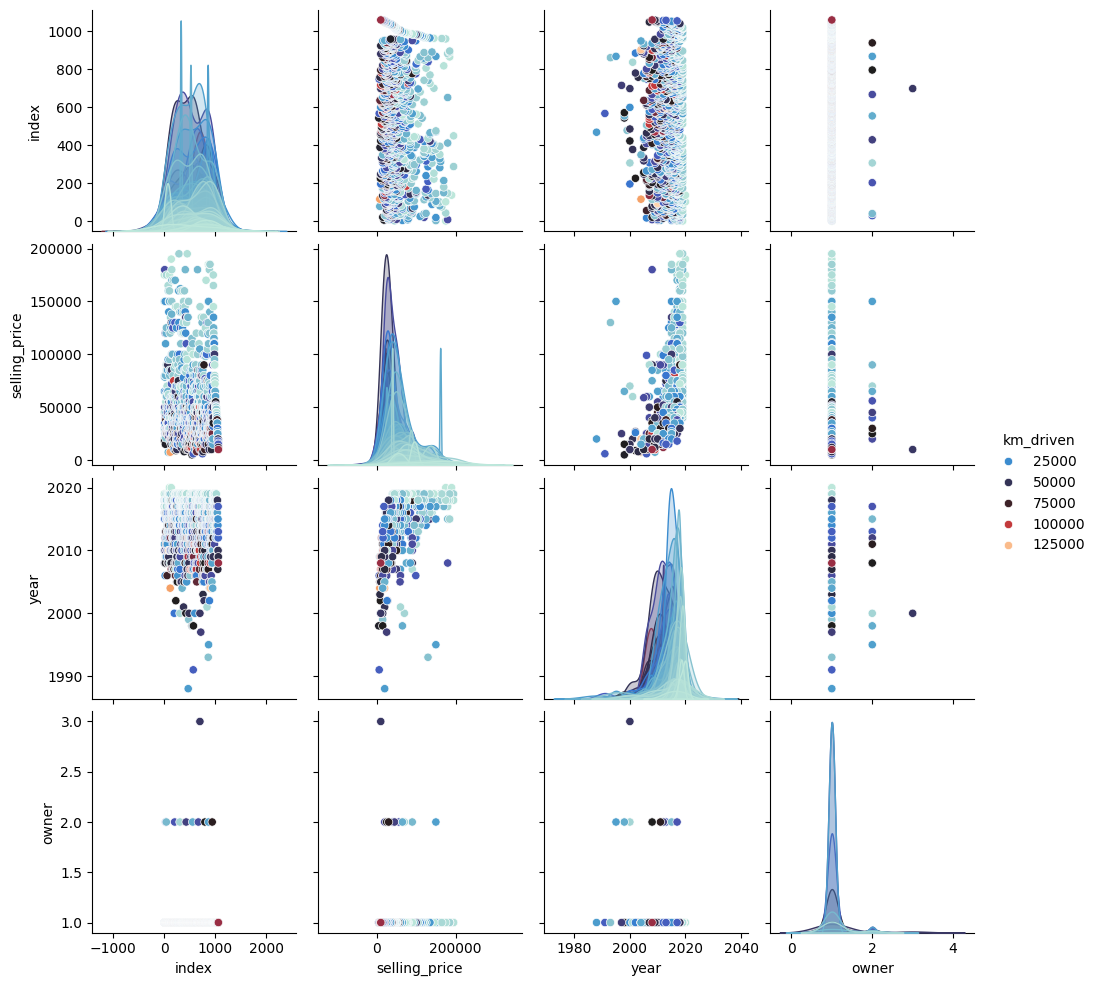

In [174]:
sns.pairplot(popular_makes, hue='km_driven', palette='icefire')

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Observations</h3>

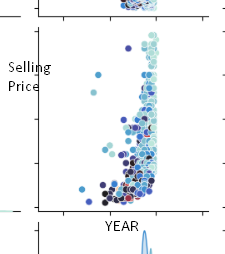

The <strong style='color:orange ; background-color:black;'>least ridden, newly manufactured motorcycels are the most expensive. </strong> 

It will be interesting to see the heatmap to see exactly which factors affect the price the most. I suspect these features will affect the price the most from this pairplot.

</div>


## Owner Pairplot

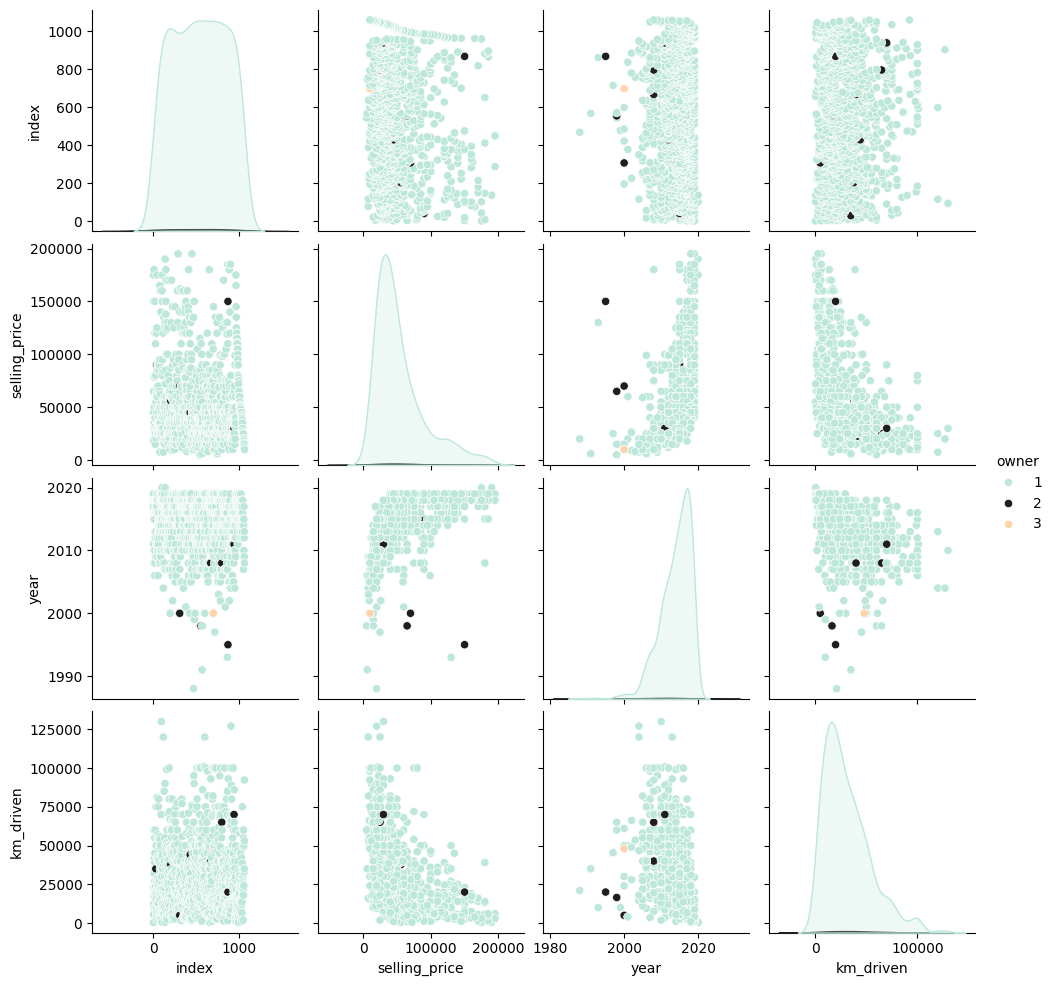

In [175]:
sns.pairplot(popular_makes, hue='owner', palette='icefire')

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Observations</h3>

There is a really bad distribution for the 'owner' category. We'll need to keep that in mind before making conjectures. 

</div>

---

# Correlations (Heatmap)

<Axes: >

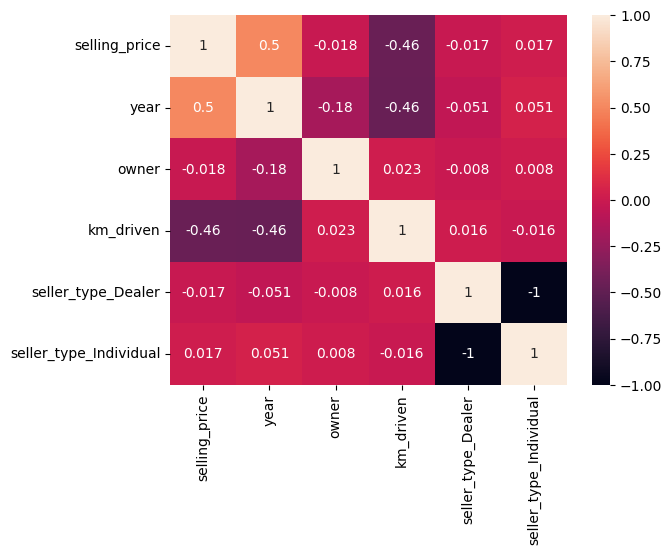

In [176]:
# Heatmap
correlation = df1.corr(numeric_only=True)
sns.heatmap(correlation, annot=True)

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Initial Correlation Observations</h3>

There are three main observations here:

1. The newer the car year, the higher the selling price. This makes sense (with few exceptions like classic cars, but we got rid of quite a few of those outliers.)
2. The less kilometers that are driven , the cheaper the price of the car generally is. 
3. <strong style='color:red'>Dealers</strong> also seem to be <strong style='color:red'>selling at less of a price than individual owners.</strong> How could that be? Shouldn't dealers try to make a profit? Don't they buy the cars from individuals and then sell them as well? 

The third observation really doesn't make sense here at face value. My guess right now, is that there are is a distribution skew between dealers and used cars. 





</div>

---

# Plots

### Plotting popular makes (By Year, Selling Price.) 

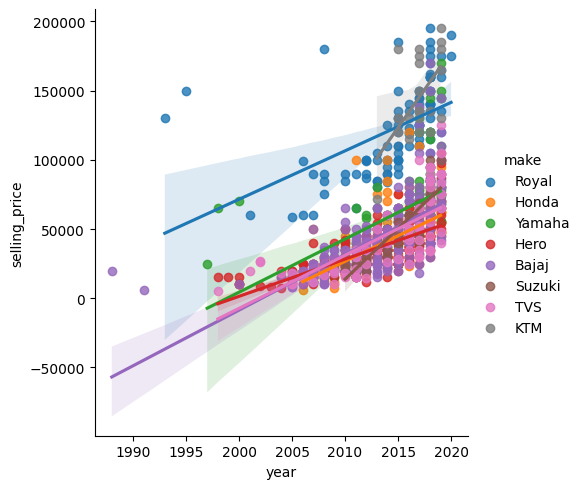

In [177]:
sns.lmplot(popular_makes, x='year', y='selling_price', hue='make', palette="tab10")

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Make sales/year observations</h3>

It appears that <strong style='color:orange ; background-color:black;'>KTM is the most expensive motorcycle.  </strong> That's interesting, I wonder if it's a special kind of motorcycle?


This plot effectively shows us the <strong style='color:orange ; background-color:black;'>depreciation speed (in price) of each motorcycle make.</strong>

<strong style='color:orange ; background-color:black;'>Suzuki and KTM depreciate the fastest. </strong>  Age affects these motorcycles a lot!


### KTM Motorycles Google
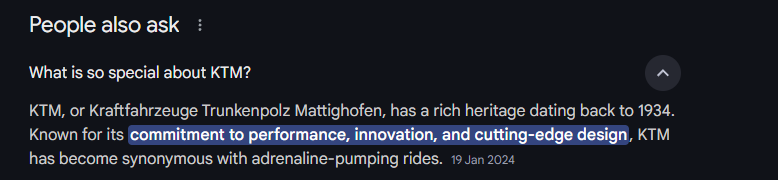


</div>

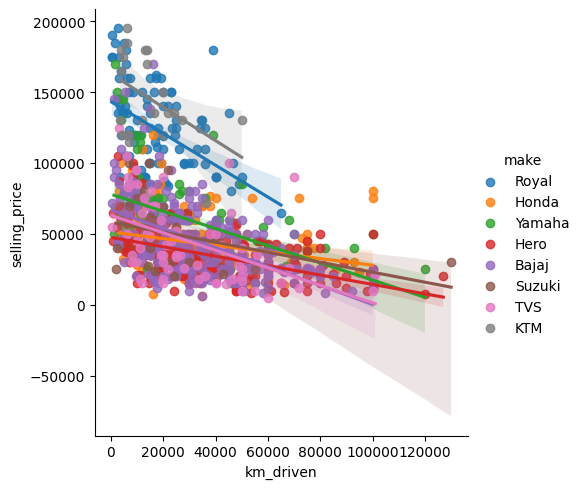

In [183]:
sns.lmplot(popular_makes, x='km_driven', y='selling_price', hue='make', palette='tab10')

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Observations</h3>

In the previous plot, we checked how fast each make of popular motorcycles depreciates by the age column.

Now, let's check the depreciation speed by km_driven.

<strong style='color:orange ; background-color:black;'>KTM and Royal depreciates far faster per km than other motorcycles</strong>. This makes sense as a luxury brand. The taller you are, the harder you fall. 

But there does seem to be some disproportionality from the generic makes. Is this a problem?

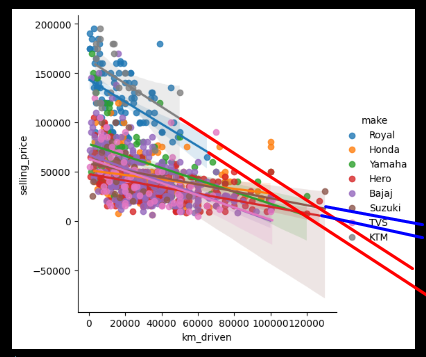

<strong style='color:orange ; background-color:black;'>NO. </strong>

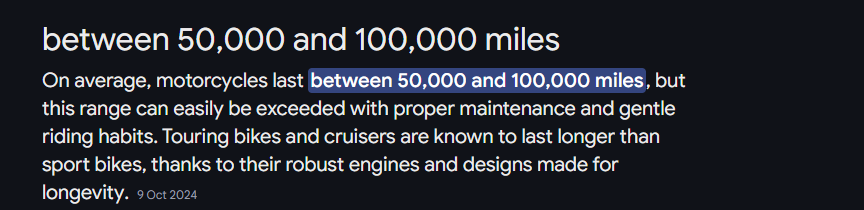

No matter which brand you have, <strong style='color:orange ; background-color:black;'> once you hit around 100,000 km on the odometer, the brand of motorcycle doesn't affect the price as much. </strong> This is because the motorcycle is at it's end of life.

Also, predicting that trend further puts it into a negative price. 

Last time we checked, we typically don't pay people when selling our stuff. We get money, not pay when selling something. 

</div>

### Bar plot -- Average km driven during sale

<Axes: xlabel='make', ylabel='km_driven'>

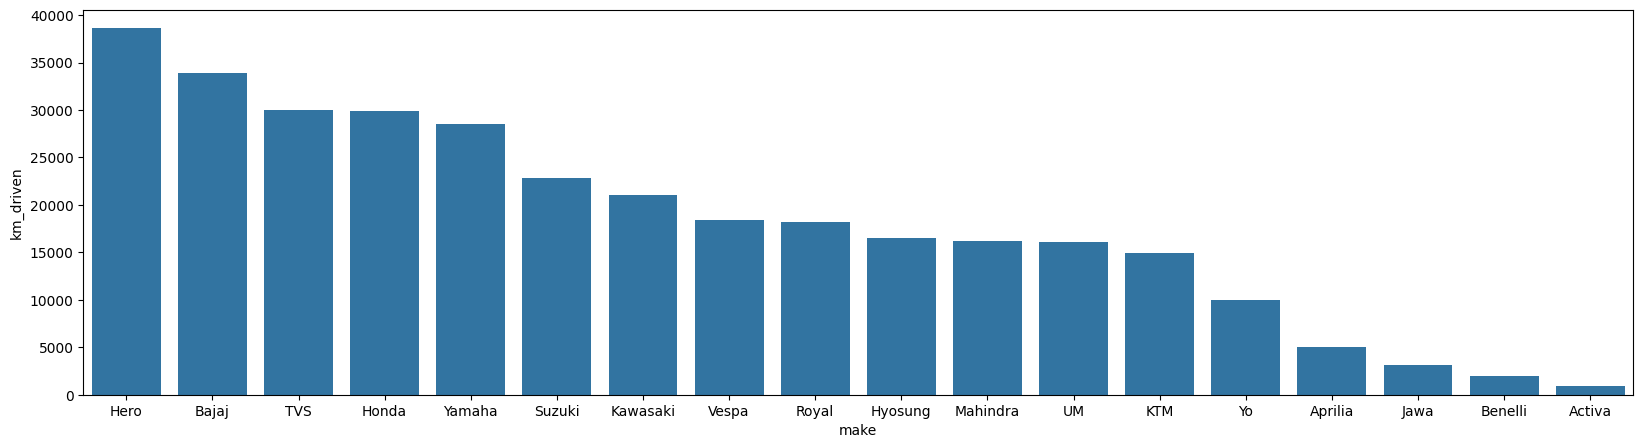

In [ ]:
# Next, let's check what the highest average kilometers are during a sale. This can ROUGHLY indicate better reliability.

# Making a groupby for each make with the aggregate as the average. 
groupby = df.groupby(['make'])[['km_driven']].mean()

# Sorts the values, starting with the highest value. 
groupby = groupby.sort_values('km_driven', ascending=False).reset_index()

# Adjusting to a nicer figure size.
plt.figure(figsize=(20,5))

# Creating a bar plot
sns.barplot(groupby, x='make', y='km_driven')

<div style="border: 3px dashed white; padding: 10px;"> 
<h3>Observations</h3>

<strong style='color:orange ; background-color:black;'>Hero Bajaj, TVS, and Honda have the highest average odometer reading during the sale.  </strong>

This could be indicative that these motorcycle brands are the most reliable.

### Google Search

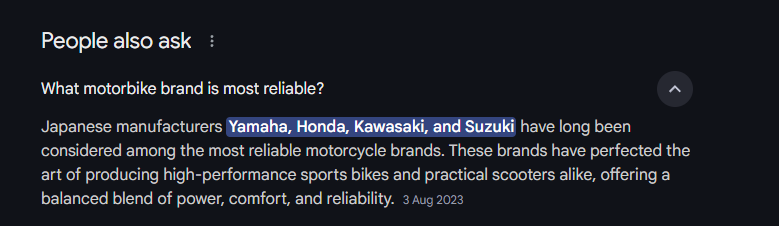

It appears that some of these motorcycles are missing from the google search. Hero and Bajaj I believe are Indian motorcycle brands -- This leads me to believe this dataset is likely an Indian one.

</div>

---

<h3><b>Results and summary:</b></h3>

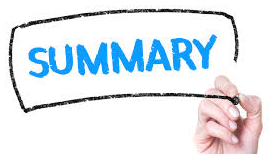

##### Selling Price Features
The features <strong style='color:orange ; background-color:black;'>that affect the selling-price the most</strong> are the <strong style='color:orange ; background-color:black;'>kilometers driven and the age of the motorcycle. </strong> Along with this, a couple of key, luxury motorcycle brands such as <strong style='color:orange ; background-color:black;'> KTM and Royal are particularly expensive. </strong> Due to there being very low amount of rows and an unequal distribution, we cannot conclude whether/how much the dealership markup affects the selling price. All of the other motorcycle brands do differ somewhat with their price-pools, but fall along the same general price line.

#### Depreciation Features
No matter the brand <strong style='color:orange ; background-color:black;'> the slope of the price moves at or close to 0 currency at 100,0000 km on the odometer </strong> this means that luxury brands like KTM and Royal will depreciate significantly faster.

<strong style='color:orange ; background-color:black;'>Hero Bajaj, TVS, and Honda have the highest average odometer reading during the sale.</strong> This could mean (but not necessarily) that these brands are the most reliable.

#### Summary 

There wasn't too much left of the data due to the distribution skew and lack of rows unfortunately. But we were at least able to find out the following: 

* What the possible most reliable motorcycle brands are. 

* What the luxury brand motorcycles are

* Which makes depreciate the fastest, and which ones do not.

* That all motorcycles, regardless of brand, is roughly about the same price at it's end of life, 100km




<h3><b>Ideas for further improvements:</b></h3>

* More rows and columns. There was not enough dealership values or 2nd, 3rd hand ownership values.

* Having extra information such as features (digital UI, high performance, radar-system,  walking mode, suspension, premium seating)

* This appears to be an Indian dataset, maybe tie this into American and European datasets to see the difference? 
